Rodent observer
===============

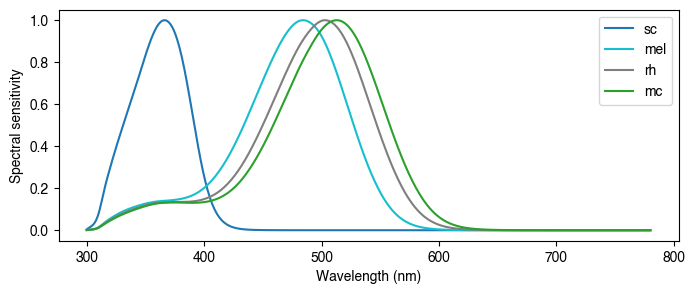

In [4]:
import pandas as pd

from pysilsub import observers, problems

# Create custom rodent model
class Rodent(observers._Observer):
    def __init__(self):
        super().__init__()

# Instantiate observer class
mouse = Rodent()

# Add action spectra and modify class attributes
mouse.action_spectra = pd.read_csv(
    '../../data/rodent_action_spectra.csv',
    index_col='Wavelength'
)
mouse.photoreceptors = mouse.action_spectra.columns.tolist()
mouse.photorecptor_colors = {
        "sc": "tab:blue",
        "mel": "tab:cyan",
        "rh": "tab:grey",
        "mc": "tab:green"
}
mouse.plot_action_spectra(figsize=(8, 3));

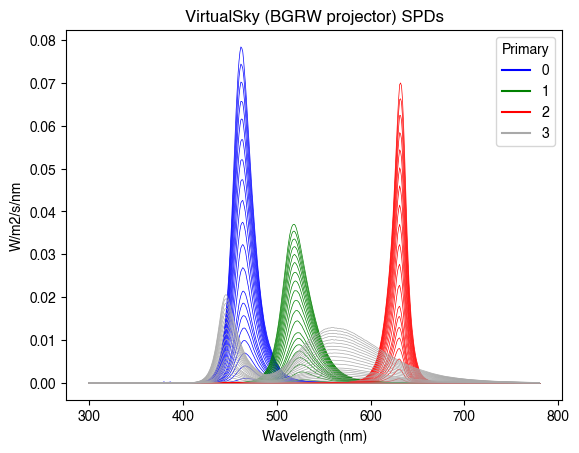

In [35]:
ssp = problems.SilentSubstitutionProblem.from_package_data('VirtualSky')
ssp.observer = mouse
# Adjust wavelengths
ssp.calibration = ssp.calibration.reindex(range(300, 781, 1), axis=1).fillna(0)
_ = ssp.plot_calibration_spds()

In [40]:
ssp.ignore = ['rh']
ssp.minimize = ['sc', 'mc']
ssp.modulate = ['mel']
ssp.target_contrast = 'max'
ssp.print_problem()

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: VirtualSky (BGRW projector)
Ignoring: ['rh']
Minimising: ['sc', 'mc']
Modulating: ['mel']
Target contrast: [inf]
Background: None




In [41]:
solution = ssp.optim_solve()

> No background specified, will optimise background.
> Aiming to maximise contrast.
> Performing local optimization with SLSQP.
  NIT    FC           OBJFUN            GNORM
    1    10    -3.389784E+01     2.926002E+00
    2    20    -2.168352E+01     4.704042E+00
    3    31    -1.711569E+00     4.996060E+00
    4    41    -1.251245E+00     6.640282E+00
    5    52    -1.456550E+00     6.593732E+00
    6    61    -2.746210E+00     7.927179E+00
    7    74    -3.673497E+00     7.949676E+00
    8    88    -2.335068E+00     7.950416E+00
    9   103    -2.209161E+00     7.950869E+00
   10   113    -3.698942E+00     8.620922E+00
   11   123    -6.713475E+00     9.539943E+00
   12   133    -4.348392E+00     1.105116E+01
   13   143    -2.137555E+00     1.573314E+01
   14   155    -2.051828E+00     1.553882E+01
   15   165    -2.102160E+00     1.503273E+01
   16   174    -2.274485E+00     1.334335E+01
   17   183    -6.662861E+00     1.488501E+01
   18   194    -2.526530E+00     1.528350E+0

In [42]:
bg_ao, mod_ao = ssp.smlri_calculator(solution.x)
df_ao = (
    pd.concat([bg_ao, mod_ao], axis=1)
    .T.melt(
        value_name="aopic",
        var_name="Photoreceptor",
        ignore_index=False,
    )
    .reset_index()
    .rename(columns={"index": "Spectrum"})
)

<AxesSubplot: xlabel='Photoreceptor', ylabel='aopic'>

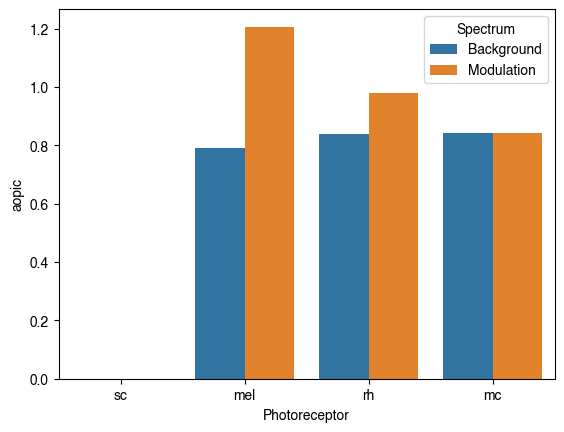

In [43]:
import seaborn as sns

sns.barplot(
    data=df_ao, x="Photoreceptor", y="aopic", hue="Spectrum")


In [45]:
bg_spd = ssp.predict_multiprimary_spd(
    solution.x[: ssp.nprimaries], name="Background"
)
mod_spd = ssp.predict_multiprimary_spd(
    solution.x[ssp.nprimaries : ssp.nprimaries * 2],
    name="Modulation",
)

<AxesSubplot: xlabel='Wavelength'>

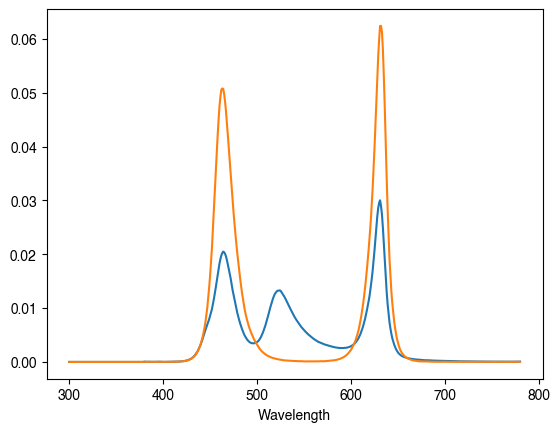

In [47]:
bg_spd.plot(); mod_spd.plot()